# Estratégia de backtesting

In [17]:
import pandas as pd
import numpy as np

In [18]:
X_back = pd.read_csv('../dados_backtest.csv')
X_back['signal']= pd.read_csv('../sinal_pred.csv')['0'].to_numpy()

In [19]:
X_back["mme8"] = X_back["Close"].ewm(span=8, min_periods=8).mean()
X_back["mme80"] = X_back["Close"].ewm(span=80, min_periods=80).mean()

X_back["eden"] = (X_back["mme8"] > X_back["mme8"].shift(1)) & (X_back["mme80"] > X_back["mme80"].shift(1))

X_back.dropna(inplace=True)

X_back.head()

,datetime,reddit_op,news_op,Open,High,Low,Close,Adj Close,Volume,SMA,...,PETR3: (Brazil),PETR4: (Brazil),Petrobras: (Brazil),Petróleo: (Brazil),oil_price,bova,signal,mme8,mme80,eden
79,2020-11-04,0.524211,0.524211,20.049999,20.129999,19.32,19.840000,11.161819,17728100.0,10.987415,...,53.0,64.0,16.0,74.0,39.150002,97811.0,1.0,19.667697,21.258313,False
80,2020-11-05,0.524181,0.524181,20.070000,20.090000,19.76,19.940001,11.218079,11439300.0,11.163694,...,56.0,55.0,15.0,65.0,38.790001,100774.0,1.0,19.728209,21.220813,False
81,2020-11-06,0.524150,0.524150,19.629999,19.980000,19.59,19.870001,11.178697,13781400.0,11.186198,...,27.0,61.0,14.0,61.0,37.139999,100799.0,1.0,19.759719,21.182532,False
82,2020-11-09,0.524120,0.524120,21.010000,22.480000,21.01,21.900000,12.320758,40041000.0,11.572511,...,74.0,90.0,21.0,62.0,40.290001,103913.0,1.0,20.235337,21.202791,True
83,2020-11-10,0.524089,0.524089,22.100000,23.730000,22.00,23.639999,13.299667,53205100.0,12.266374,...,92.0,100.0,23.0,75.0,41.360001,105351.0,1.0,20.991928,21.271365,True


In [20]:
X_back["signal"].shift(1)

79     NaN
80     1.0
81     1.0
82     1.0
83     1.0
      ... 
300    0.0
301    0.0
302    0.0
303    0.0
304    0.0
Name: signal, Length: 226, dtype: float64

In [21]:
condition_1 = X_back["signal"].shift(1) == True
condition_2 = X_back["eden"].shift(1) == True 
condition_3 = X_back["High"] > X_back["High"].shift(1)
tick = 0.01

X_back["buy_price"] = np.where(
    condition_1 & condition_2 & condition_3, 
    np.where(X_back["Open"] > X_back["High"].shift(1), X_back["Open"], X_back["High"].shift(1) + tick),
    np.nan
)

In [22]:
X_back.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 79 to 304
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   datetime                      226 non-null    object 
 1   reddit_op                     226 non-null    float64
 2   news_op                       226 non-null    float64
 3   Open                          226 non-null    float64
 4   High                          226 non-null    float64
 5   Low                           226 non-null    float64
 6   Close                         226 non-null    float64
 7   Adj Close                     226 non-null    float64
 8   Volume                        226 non-null    float64
 9   SMA                           226 non-null    float64
 10  EMA                           226 non-null    float64
 11  macd                          226 non-null    float64
 12  macd_h                        226 non-null    float64
 13  macd

In [23]:
max_high = X_back["High"].rolling(3).max()
min_low = X_back["Low"].rolling(3).min()

amplitude = (max_high.shift(1) - min_low.shift(1))
entry = X_back["High"].shift(1)

X_back["target"] =  amplitude + entry

X_back["stop"] = X_back["Low"].shift(2) - tick


In [24]:
import math

# Create a function to round any number to the smalles multiple of 100
def round_down(x):
    return int(math.floor(x / 100.0)) * 100

def backtest_algorithm(
    df,
    capital_exposure,
    initial_capital):

    # List with the total capital after every operation
    total_capital = [initial_capital]

    # List with profits for every operation
    all_profits = [] 

    ongoing = False

    for i in range(0,len(df)):

        if ongoing == True:

            if (df["Open"].iloc[i] >= target) | (df["Open"].iloc[i] <= stop): 
                exit = df["Open"].iloc[i]

                profit = shares * (exit - entry)
                # Append profit to list and create a new entry with the capital
                # after the operation is complete
                all_profits += [profit]
                current_capital = total_capital[-1] # current capital is the last entry in the list
                total_capital += [current_capital + profit]

                ongoing = False

            elif df["Low"].iloc[i] <= stop: 
                exit = stop

                profit = shares * (exit - entry)
                # Append profit to list and create a new entry with the capital
                # after the operation is complete
                all_profits += [profit]
                current_capital = total_capital[-1] # current capital is the last entry in the list
                total_capital += [current_capital + profit]

                ongoing = False

            elif df["High"].iloc[i] >= target: 
                exit = target

                profit = shares * (exit - entry)
                # Append profit to list and create a new entry with the capital
                # after the operation is complete
                all_profits += [profit]
                current_capital = total_capital[-1] # current capital is the last entry in the list
                total_capital += [current_capital + profit]

                ongoing = False

        else:
            if ~(np.isnan(df["buy_price"].iloc[i])):
                entry = df["buy_price"].iloc[i]
                stop = df["stop"].iloc[i]
                
                if df["Low"].iloc[i] > stop: 
                    ongoing = True
                    risk = entry - stop
                    target = df["target"].iloc[i]
                    shares = round_down(capital_exposure / risk)

    return all_profits, total_capital

In [25]:
def get_drawdown(data, column = "Close"):
    data["Max"] = data[column].cummax()
    data["Delta"] = data['Max'] - data[column]
    data["Drawdown"] = 100 * (data["Delta"] / data["Max"])
    max_drawdown = data["Drawdown"].max()
    return max_drawdown

In [26]:
import matplotlib.pyplot as plt 

def strategy_test(all_profits, total_capital):
    gains = sum(x >= 0 for x in all_profits)
    losses = sum(x < 0 for x in all_profits)
    num_operations = gains + losses
    pct_gains = 100 * (gains / num_operations)
    pct_losses = 100 - pct_gains
    total_profit = sum(all_profits)
    pct_profit = (total_profit / total_capital[0]) * 100
    
    # Compute drawdown
    total_capital = pd.DataFrame(data=total_capital, columns=["total_capital"])
    drawdown = get_drawdown(data=total_capital, column="total_capital")

    # Compute profit per operation
    profit_per_operation = pct_profit / num_operations

    return {
        "num_operations": num_operations,
        "gains": gains ,
        "pct_gains": pct_gains.round(),
        "losses": losses,
        "pct_losses": pct_losses.round(), 
        "total_profit": total_profit,
        "pct_profit": pct_profit,
        "drawdown": drawdown,
        "profit_per_operation": profit_per_operation
    }
def capital_plot(total_capital, all_profits):
  all_profits = [0] + all_profits # make sure both lists are the same size
  cap_evolution = pd.DataFrame({'Capital': total_capital, 'Profit': all_profits})
  plt.title("Curva de Capital")
  plt.xlabel("Total Operações")
  cap_evolution['Capital'].plot()

In [27]:
all_profits, total_capital = backtest_algorithm(
    df=X_back,
    capital_exposure=1000,
    initial_capital=100000)

In [28]:
all_profits

[863.9998168945308,
 429.99935150146484,
 3044.998077392575,
 3150.0011444091756,
 -1190.0003051757722,
 1077.9994659423817,
 -1937.9997253417969,
 -989.9994277954125,
 1759.997924804685,
 685.0004196166957,
 -959.9985351562538,
 3086.998558044471,
 1134.9992752075195,
 2564.997535705563,
 -956.0004272460944]

In [29]:
statistics = strategy_test(all_profits, total_capital)
statistics = pd.DataFrame.from_dict(statistics, orient='index')
statistics.round(2)

,0
num_operations,15.00
gains,10.00
pct_gains,67.00
losses,5.00
pct_losses,33.00
total_profit,11764.99
pct_profit,11.76
drawdown,2.83
profit_per_operation,0.78


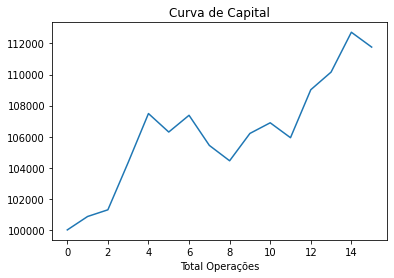

In [30]:
capital_plot(total_capital, all_profits)


In [31]:
def expected_value(all_profits):
    all_positives = [x for x in all_profits if x >= 0]
    average_gain = sum(all_positives) / len(all_positives)

    all_negatives = [x for x in all_profits if x < 0]
    average_loss = sum(all_negatives) / len(all_negatives)

    num_operations = len(all_profits)
    pct_gains = (len(all_positives) / num_operations)
    pct_losses = 1 - pct_gains
    
    expected_value = (average_gain * pct_gains) + (average_loss * pct_losses)
    
    result = pd.DataFrame.from_dict({
        "average_gain": average_gain,
        "average_loss": average_loss,
        "pct_gains": pct_gains,
        "pct_losses": pct_losses,
        "expected_value": expected_value
    }, orient="index")
    result.columns = ["result"]
    return result

In [32]:
ev = expected_value(all_profits)
ev

,result
average_gain,1779.899157
average_loss,-1206.799684
pct_gains,0.666667
pct_losses,0.333333
expected_value,784.332877
